Epoch [500/100000], Loss: 323.419403
Epoch [1000/100000], Loss: 10.427391
Epoch [1500/100000], Loss: 5.412652
Epoch [2000/100000], Loss: 27.852139
Epoch [2500/100000], Loss: 35.891495
Epoch [3000/100000], Loss: 2.293629
Epoch [3500/100000], Loss: 1.555795
Epoch [4000/100000], Loss: 13.271076
Epoch [4500/100000], Loss: 11.296408
Epoch [5000/100000], Loss: 7.234286
Epoch [5500/100000], Loss: 0.663212
Epoch [6000/100000], Loss: 2.061835
Epoch [6500/100000], Loss: 109.406418
Epoch [7000/100000], Loss: 0.581782
Epoch [7500/100000], Loss: 0.546872
Epoch [8000/100000], Loss: 3.866342
Epoch [8500/100000], Loss: 1.689538
Epoch [9000/100000], Loss: 3.424054
Epoch [9500/100000], Loss: 0.180756
Epoch [10000/100000], Loss: 0.105322
Epoch [10500/100000], Loss: 0.372928
Epoch [11000/100000], Loss: 0.166524
Epoch [11500/100000], Loss: 1.124746
Epoch [12000/100000], Loss: 0.413808
Epoch [12500/100000], Loss: 4.543509
Epoch [13000/100000], Loss: 0.093137
Epoch [13500/100000], Loss: 0.382638
Epoch [14000

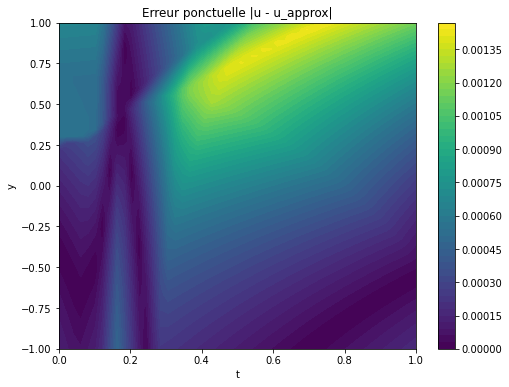

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------------
# Paramètres du problème
# -----------------------------
r = 0.05       # taux d'intérêt
sigma = 0.2    # volatilité
K = 100        # strike
T = 1.0        # maturité
Smax = 250     # S max pour la pénalisation
N_int = 2000   # nb de points intérieurs
N_bc = 200     # nb de points sur frontière/terminal
num_epochs = 100_000
lr = 1e-3

# -----------------------------
# Modèle Deep Galerkin
# -----------------------------
class DGMNet(nn.Module):
    def __init__(self, dim_in=2, dim_hidden=64, dim_out=1, n_layers=4):
        super(DGMNet, self).__init__()
        self.input_layer = nn.Linear(dim_in, dim_hidden)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(dim_hidden, dim_hidden) for _ in range(n_layers)
        ])
        self.output_layer = nn.Linear(dim_hidden, dim_out)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t, s):
        x = torch.cat((t, s), dim=1)
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        out = self.output_layer(x)
        return out

# -----------------------------
# Méthodes pour calcul des dérivées et résidu PDE
# -----------------------------
def derivatives_u(model, t, s):
    t.requires_grad = True
    s.requires_grad = True
    u = model(t, s)
    dudt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                               retain_graph=True, create_graph=True)[0]
    duds = torch.autograd.grad(u, s, grad_outputs=torch.ones_like(u), 
                               retain_graph=True, create_graph=True)[0]
    d2uds2 = torch.autograd.grad(duds, s, grad_outputs=torch.ones_like(u), 
                                 retain_graph=True, create_graph=True)[0]
    return u, dudt, duds, d2uds2

def pde_residual(model, t, s):
    u, dudt, duds, d2uds2 = derivatives_u(model, t, s)
    return dudt + 0.5 * sigma**2 * s**2 * d2uds2 + r * s * duds - r * u

def bs_price_call(t, s, K, T, r, sigma):
    tau = T - t
    from torch.distributions.normal import Normal
    N = Normal(0., 1.)
    d1 = (torch.log(s / K) + (r + 0.5 * sigma**2) * tau) / (sigma * torch.sqrt(tau) + 1e-9)
    d2 = d1 - sigma * torch.sqrt(tau)
    call = s * N.cdf(d1) - K * torch.exp(-r * tau) * N.cdf(d2)
    call = torch.where(tau < 1e-14, torch.relu(s - K), call)
    return call

# -----------------------------
# Entraînement du modèle
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DGMNet(dim_in=2, dim_hidden=64, dim_out=1, n_layers=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    t_int = torch.rand(N_int, 1).to(device) * T
    s_int = torch.rand(N_int, 1).to(device) * Smax
    res_int = pde_residual(model, t_int, s_int)
    loss_pde = torch.mean(res_int**2)

    s_term = torch.linspace(0, Smax, N_bc).view(-1, 1).to(device)
    t_term = torch.ones_like(s_term).to(device) * T
    u_term = model(t_term, s_term)
    payoff = torch.relu(s_term - K)
    loss_terminal = torch.mean((u_term - payoff)**2)

    t_0 = torch.rand(N_bc, 1).to(device) * T
    s_0 = torch.zeros_like(t_0).to(device)
    u_0 = model(t_0, s_0)
    loss_s0 = torch.mean(u_0**2)

    t_smax = torch.rand(N_bc, 1).to(device) * T
    s_smax = (torch.ones_like(t_smax) * Smax).to(device)
    u_smax = model(t_smax, s_smax)
    target_smax = s_smax - K * torch.exp(-r * (T - t_smax))
    loss_smax = torch.mean((u_smax - target_smax)**2)

    loss = loss_pde + loss_terminal + loss_s0 + loss_smax

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# -----------------------------
# Évaluation et tracé des erreurs
# -----------------------------
ntest = 50
stest = 50
t_vals = torch.linspace(0, T, ntest).to(device)
s_vals = torch.linspace(0, Smax, stest).to(device)

err_max = 0.0
for i in range(ntest):
    for j in range(stest):
        tt = t_vals[i].view(-1, 1)
        ss = s_vals[j].view(-1, 1)
        u_approx = model(tt, ss)
        u_exact = bs_price_call(tt, ss, K, T, r, sigma)
        err_max = max(err_max, torch.abs(u_approx - u_exact).item())

print(f"Erreur L∞ approx = {err_max:.6f}")

# Carte des erreurs ponctuelles
L = 1.0
ny = 50
y_vals = torch.linspace(-L, L, ny).to(device)
s_vals_exp = torch.exp(y_vals)
err_mat = np.zeros((ntest, ny))

for j in range(ntest):
    for i in range(ny):
        tt = t_vals[j].view(-1, 1)
        ss = s_vals_exp[i].view(-1, 1)
        u_approx = model(tt, ss)
        u_exact = bs_price_call(tt, ss, K, T, r, sigma)
        err_mat[j, i] = torch.abs(u_approx - u_exact).item()

import matplotlib.pyplot as plt
T_grid = t_vals.cpu().numpy()
Y_grid = y_vals.cpu().numpy()

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(T_grid, Y_grid, indexing='ij')
plt.contourf(X, Y, err_mat, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('y')
plt.title("Erreur ponctuelle |u - u_approx|")
plt.show()


In [4]:
import torch
import numpy as np

n_t = 50  # Number of time points
n_S = 100  # Number of asset price points
t_vals = torch.linspace(0, T, n_t).to(device)  # Time points
S_vals = torch.linspace(0, Smax, n_S).to(device)  # Asset price points

In [5]:
results = np.zeros((n_t, n_S))
exact_results = np.zeros((n_t, n_S))

for i, t in enumerate(t_vals):
    for j, S in enumerate(S_vals):
        tt = t.view(1, -1)  # Reshape for model input
        SS = S.view(1, -1)
        model_prediction = model(tt, SS).item()  # Model's output
        exact_solution = bs_price_call(tt, SS, K, T, r, sigma).item()  # Black-Scholes formula
        
        results[i, j] = model_prediction
        exact_results[i, j] = exact_solution

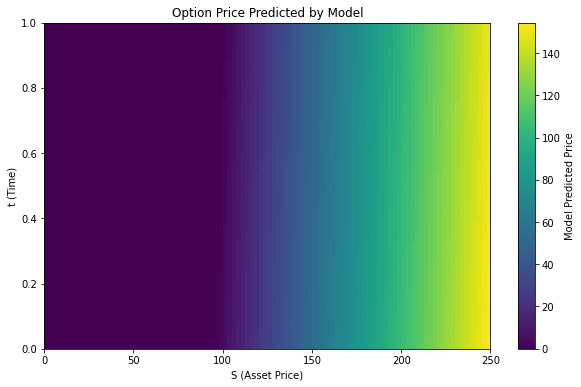

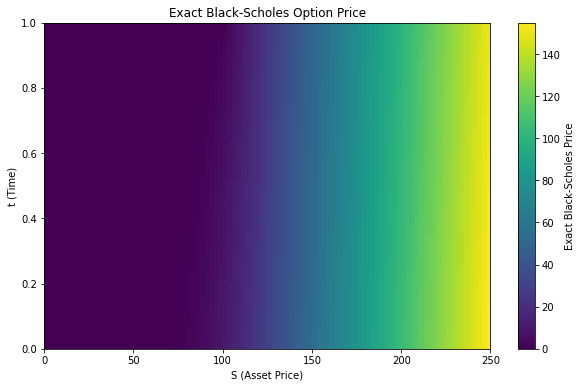

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(results, extent=[0, Smax, 0, T], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Model Predicted Price')
plt.title('Option Price Predicted by Model')
plt.xlabel('S (Asset Price)')
plt.ylabel('t (Time)')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(exact_results, extent=[0, Smax, 0, T], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Exact Black-Scholes Price')
plt.title('Exact Black-Scholes Option Price')
plt.xlabel('S (Asset Price)')
plt.ylabel('t (Time)')
plt.show()
